**Requirements**

*   Pandas == 1.1.5
*   Numpy == 1.19.5
*   CatBoost == 0.24.4
*   Elemento de la lista






In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
from sklearn.metrics import mean_squared_error, mean_absolute_error
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize']=(20,8)

# **Process**


In [3]:
import zipfile
z = zipfile.ZipFile('competitive-data-science-predict-future-sales.zip')
z.extractall()
z.namelist()

['item_categories.csv',
 'items.csv',
 'sales_train.csv',
 'sample_submission.csv',
 'shops.csv',
 'test.csv']

In [4]:
sales = pd.read_csv('sales_train.csv')
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


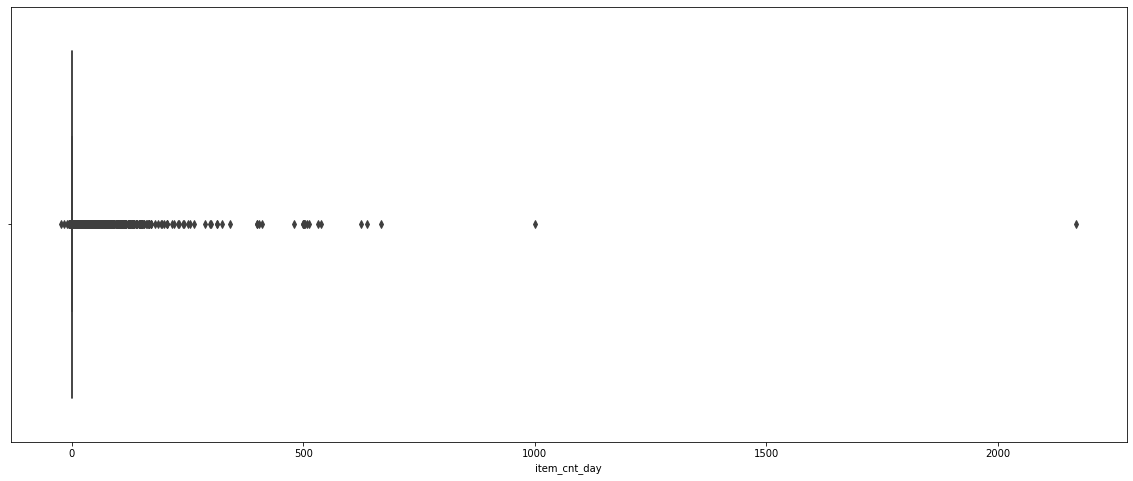

In [5]:
sns.boxplot(x=sales['item_cnt_day'])

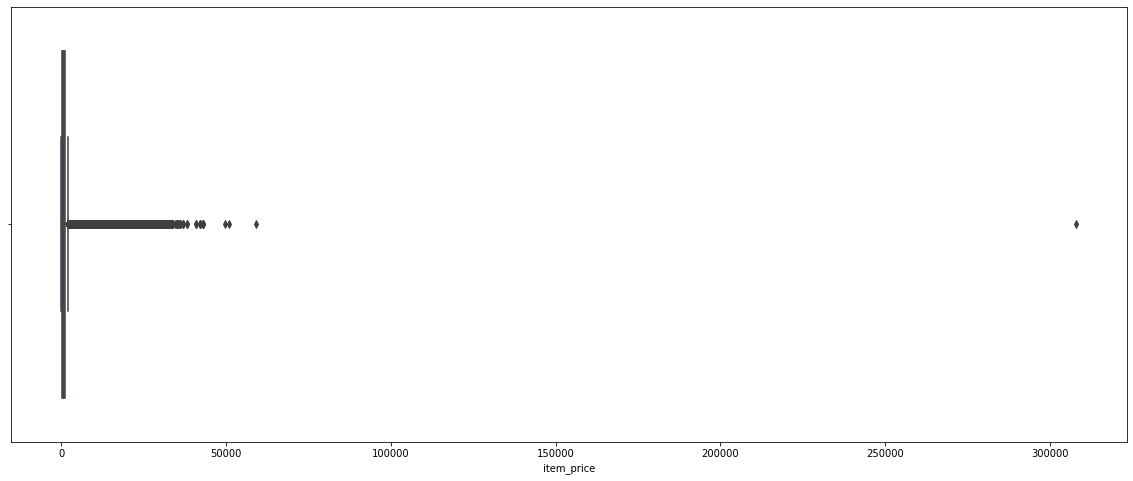

In [6]:
sns.boxplot(x=sales['item_price'])

Drop outliers

In [7]:
sales = sales[sales['item_price'] < 5000]
sales = sales[sales['item_cnt_day'] < 800]
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2902016.0,14.547435,9.424546,0.0,6.0,14.0,23.0,33.00
shop_id,2902016.0,33.014785,16.223954,0.0,22.0,31.0,47.0,59.00
item_id,2902016.0,10203.923048,6346.229392,0.0,4421.0,9355.0,15757.0,22169.00
item_price,2902016.0,745.103112,787.152770,-1.0,249.0,399.0,979.0,4999.24
item_cnt_day,2902016.0,1.240663,2.216300,-22.0,1.0,1.0,1.0,669.00


## **Pivot Table**

In [8]:
test = pd.read_csv('test.csv')
test.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,214200.0,107099.500000,61834.358168,0.0,53549.75,107099.5,160649.25,214199.0
shop_id,214200.0,31.642857,17.561933,2.0,16.00,34.5,47.00,59.0
item_id,214200.0,11019.398627,6252.644590,30.0,5381.50,11203.0,16071.50,22167.0


Build a pivot table to get lags. Contains all months.

In [9]:
data = sales.groupby(['date_block_num', 'item_id', 'shop_id'])['item_cnt_day'].sum().reset_index()
data['item_cnt_month'] = data['item_cnt_day']
data = data.drop('item_cnt_day', axis=1)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,1591567.0,14.647324,9.539553,0.0,6.0,14.0,23.0,33.0
item_id,1591567.0,10688.388204,6257.186275,0.0,5036.0,10498.0,16100.0,22169.0
shop_id,1591567.0,32.820424,16.534284,0.0,21.0,31.0,47.0,59.0
item_cnt_month,1591567.0,2.262189,8.452472,-22.0,1.0,1.0,2.0,1644.0


In [10]:
data = pd.pivot_table(data, index=['item_id', 'shop_id'], columns='date_block_num', values='item_cnt_month', aggfunc=np.sum, fill_value=0)
data = data.reset_index()
data

date_block_num,item_id,shop_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,3,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418120,22168,12,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
418121,22168,16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
418122,22168,42,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
418123,22168,43,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
test = test[['item_id', 'shop_id']]
test = pd.merge(test, data, on=['item_id','shop_id'], how='left')
test = test.fillna(0)
test.head()

,item_id,shop_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,5037,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5320,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5233,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5232,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5268,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Encodings**

Build mean encodings for categories and used extracted subcategories from category names

In [12]:
items = pd.read_csv('items.csv')
items = items.set_index('item_id')['item_category_id']
items.head()

item_id
0    40
1    76
2    40
3    40
4    40
Name: item_category_id, dtype: int64

In [13]:
category = pd.read_csv('item_categories.csv')
category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [14]:
sub = []
for x in category['item_category_name']:
    sub.append(x.split(' ')[0])
category['sub_cat_name'] = sub 
category.head()

,item_category_name,item_category_id,sub_cat_name
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


In [15]:
enc = {}
i = 0
for x in category['sub_cat_name']:
    if x not in enc:
        enc[x] = i
        i += 1

category['sub_cat_id'] = category['sub_cat_name'].map(enc)
category = category.set_index('item_category_id')['sub_cat_id']
category.head()

item_category_id
0    0
1    1
2    1
3    1
4    1
Name: sub_cat_id, dtype: int64

In [16]:
test['category_id'] = test['item_id'].map(items)
test['sub_cat_id'] = test['category_id'].map(category)
test.head()

,item_id,shop_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,category_id,sub_cat_id
0,5037,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,19,5
1,5320,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,9
2,5233,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,19,5
3,5232,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,23,5
4,5268,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,5


In [17]:
test = test.drop(['item_id', 'shop_id'], axis =1)
test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,category_id,sub_cat_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,19,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,9
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,19,5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,23,5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,5


In [18]:
cat_feat = ['category_id', 'sub_cat_id']
for c in cat_feat:
    cums = test.groupby(c)[33].cumsum() - test[33]
    cumc = test.groupby(c).cumcount()
    test[c+'_mean'] = cums/cumc
test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,category_id,sub_cat_id,category_id_mean,sub_cat_id_mean
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,19,5,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,9,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,19,5,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,23,5,NaN,0.500000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,5,NaN,0.333333


In [19]:
c_m = test.loc[test['category_id_mean'].isna() == False, 'category_id_mean'].mean()
c_s_m = test.loc[test['sub_cat_id_mean'].isna() == False, 'sub_cat_id_mean'].mean()
c_m, c_s_m

(0.30463153377400937, 0.3082526673352163)

In [20]:
test['category_id_mean'] = test['category_id_mean'].fillna(c_m)
test['sub_cat_id_mean'] = test['sub_cat_id_mean'].fillna(c_s_m)
test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,category_id,sub_cat_id,category_id_mean,sub_cat_id_mean
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,19,5,0.304632,0.308253
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,9,0.304632,0.308253
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,19,5,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,23,5,0.304632,0.500000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,5,0.304632,0.333333


In [21]:
sales['item_category_id'] = sales['item_id'].map(items)
category_p = sales.groupby(['item_category_id'])['item_price'].mean()
category_p.head()

item_category_id
0      87.800000
1     215.500000
2    2119.365027
3    2002.340289
4     554.696081
Name: item_price, dtype: float64

In [22]:
sales['sub_cat_id'] = sales['item_category_id'].map(category)
sub_cat_p = sales.groupby(['sub_cat_id'])['item_price'].mean()
sub_cat_p.head()

sub_cat_id
0      87.800000
1    1839.608114
2    1345.441896
3     712.246641
4    2731.136341
Name: item_price, dtype: float64

In [23]:
test['category_price'] = test['category_id'].map(category_p)
test['sub_cat_price'] = test['sub_cat_id'].map(sub_cat_p)
test['category_price'] = test['category_price'].fillna(category_p.mean())
test['sub_cat_price'] = test['sub_cat_price'].fillna(sub_cat_p.mean())
test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,category_id,sub_cat_id,category_id_mean,sub_cat_id_mean,category_price,sub_cat_price
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,19,5,0.304632,0.308253,1505.534278,1100.428753
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,9,0.304632,0.308253,286.209370,354.504568
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,19,5,0.000000,0.000000,1505.534278,1100.428753
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,23,5,0.304632,0.500000,1470.959494,1100.428753
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,5,0.304632,0.333333,2693.714838,1100.428753


## **Build train-validation data**

In [24]:
x = test.drop(33, axis=1)
y = test.loc[: , 33]
x.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,category_id,sub_cat_id,category_id_mean,sub_cat_id_mean,category_price,sub_cat_price
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,19,5,0.304632,0.308253,1505.534278,1100.428753
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,9,0.304632,0.308253,286.209370,354.504568
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,19,5,0.000000,0.000000,1505.534278,1100.428753
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,23,5,0.304632,0.500000,1470.959494,1100.428753
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,5,0.304632,0.333333,2693.714838,1100.428753


In [25]:
x_test = test.drop(0, axis=1)

cc = {}
for i in range(33):
    cc[i+1] = i

x_test = x_test.rename(columns=cc)
x_test.columns

Index([                 0,                  1,                  2,
                        3,                  4,                  5,
                        6,                  7,                  8,
                        9,                 10,                 11,
                       12,                 13,                 14,
                       15,                 16,                 17,
                       18,                 19,                 20,
                       21,                 22,                 23,
                       24,                 25,                 26,
                       27,                 28,                 29,
                       30,                 31,                 32,
            'category_id',       'sub_cat_id', 'category_id_mean',
        'sub_cat_id_mean',   'category_price',    'sub_cat_price'],
      dtype='object')

In [26]:
lags = [i for i in range(33)]

def feating(x):
    x['lag_mean'] = x.loc[:,lags].mean(axis=1)
    x['lag_min'] = x.loc[:,lags].min(axis=1)
    x['lag_max'] = x.loc[:,lags].max(axis=1)
    x['lag_std'] = x.loc[:,lags].std(axis=1)

    return x

x = feating(x)
x_test = feating(x_test)
x_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,category_id,sub_cat_id,category_id_mean,sub_cat_id_mean,category_price,sub_cat_price,lag_mean,lag_min,lag_max,lag_std
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,19,5,0.304632,0.308253,1505.534278,1100.428753,0.393939,0.0,3.0,0.747470
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,9,0.304632,0.308253,286.209370,354.504568,0.000000,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,19,5,0.000000,0.000000,1505.534278,1100.428753,0.303030,0.0,3.0,0.809508
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,23,5,0.304632,0.500000,1470.959494,1100.428753,0.030303,0.0,1.0,0.174078
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,5,0.304632,0.333333,2693.714838,1100.428753,0.000000,0.0,0.0,0.000000


In [27]:
from sklearn.model_selection import KFold
kf = KFold(4, shuffle=True).split(x)
ids = [(i, j) for i,j in kf]
ids

[(array([     0,      1,      2, ..., 214197, 214198, 214199]),
  array([     4,      7,      9, ..., 214189, 214190, 214194])),
 (array([     1,      2,      4, ..., 214196, 214197, 214199]),
  array([     0,      3,      8, ..., 214178, 214181, 214198])),
 (array([     0,      2,      3, ..., 214193, 214194, 214198]),
  array([     1,      5,     13, ..., 214196, 214197, 214199])),
 (array([     0,      1,      3, ..., 214197, 214198, 214199]),
  array([     2,      6,     19, ..., 214182, 214185, 214193]))]

# **LGBMRegressor**

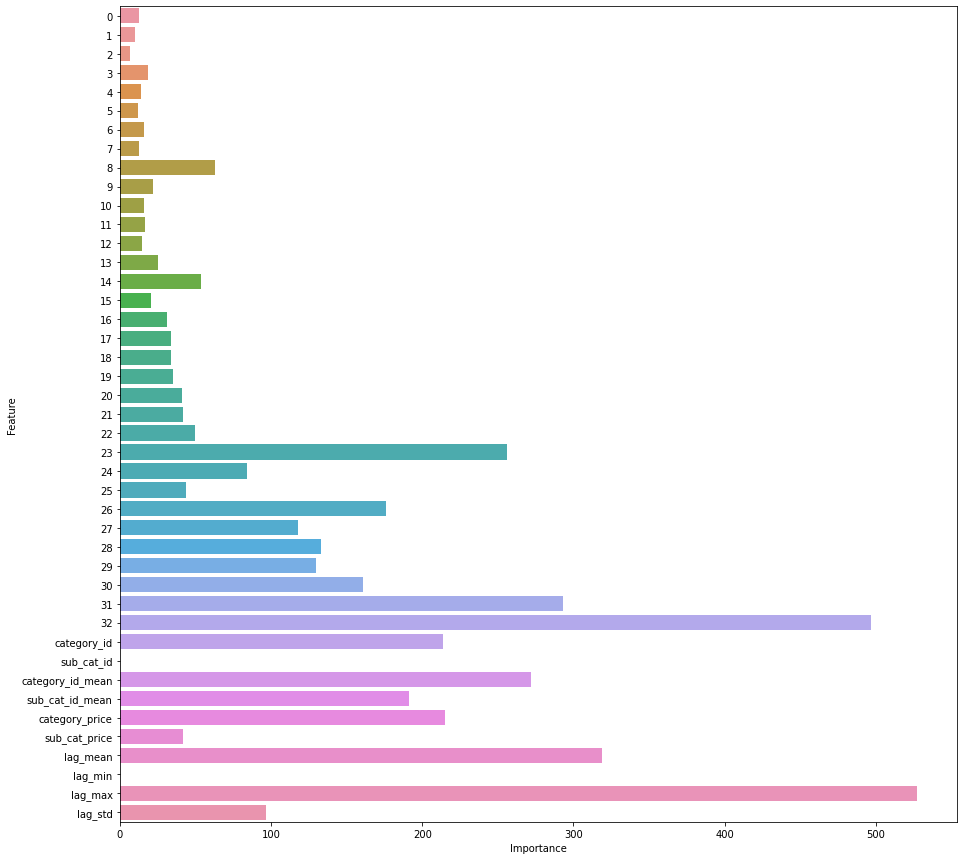

In [28]:
from lightgbm import LGBMRegressor
lg_model = LGBMRegressor(n_estimators=200, max_depth=13)
lg_model.fit(x, y)
plt.rcParams['figure.figsize']=(15,15)
f_i = pd.DataFrame({'Feature':x.columns, 'Importance':lg_model.feature_importances_})
sns.barplot(y='Feature',x='Importance', data=f_i)

# **CatBoostRegressor**

In [29]:
from catboost import CatBoostRegressor

Uncomment for model training (model from file is below)

In [30]:
'''c_model = CatBoostRegressor(n_estimators=10000, learning_rate=0.05, max_depth=13, reg_lambda=5, objective='RMSE')

i,j =ids[0]

x_train = x.iloc[i]
y_train = y.iloc[i]
x_val = x.iloc[j]
y_val = y.iloc[j]

c_model.fit(x_train, y_train, cat_features=cat_feat, eval_set=(x_val, y_val), early_stopping_rounds=30, verbose=50)

for i, j in ids[1:]:
    x_train = x.iloc[i]
    y_train = y.iloc[i]
    x_val = x.iloc[j]
    y_val = y.iloc[j]

    c_model.fit(x_train, y_train, cat_features=cat_feat, eval_set=(x_val, y_val), early_stopping_rounds=30, init_model=c_model, verbose=50)'''

0:	learn: 2.6613432	test: 2.5392715	best: 2.5392715 (0)	total: 633ms	remaining: 1h 45m 30s
50:	learn: 1.6841516	test: 1.8482385	best: 1.8482385 (50)	total: 19.5s	remaining: 1h 3m 23s
100:	learn: 1.3868498	test: 1.6553668	best: 1.6553668 (100)	total: 33.9s	remaining: 55m 20s
150:	learn: 1.2766124	test: 1.5759090	best: 1.5759090 (150)	total: 46.8s	remaining: 50m 52s
200:	learn: 1.2181928	test: 1.5271822	best: 1.5271822 (200)	total: 59.9s	remaining: 48m 41s
250:	learn: 1.1887198	test: 1.5012553	best: 1.5012503 (248)	total: 1m 13s	remaining: 47m 40s
300:	learn: 1.1669875	test: 1.4856045	best: 1.4856045 (300)	total: 1m 30s	remaining: 48m 37s
350:	learn: 1.1506182	test: 1.4752121	best: 1.4752121 (350)	total: 1m 46s	remaining: 48m 52s
400:	learn: 1.1379105	test: 1.4696142	best: 1.4696142 (400)	total: 2m 4s	remaining: 49m 36s
450:	learn: 1.1247725	test: 1.4665054	best: 1.4665054 (450)	total: 2m 23s	remaining: 50m 28s
500:	learn: 1.1119150	test: 1.4654281	best: 1.4651593 (495)	total: 2m 44s	rem

In [43]:
#c_model.save_model('c_model.cbm')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model from file

In [44]:
c_model = CatBoostRegressor().load_model('c_model.cbm')

In [45]:
pred = c_model.predict(x_test).clip(0,20)
ans = pd.DataFrame({'ID':[i for i in range(len(x_test))], 'item_cnt_month':pred}).set_index('ID')
ans.describe().T

,count,mean,std,min,25%,50%,75%,max
item_cnt_month,214200.0,0.258898,0.67965,0.0,0.064175,0.133737,0.218345,20.0


In [32]:
ans.to_csv('submission.csv')